In [2]:
import pandas as pd
data = pd.read_csv('../data/clean.csv')
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We can now apply the NOTEARS algorithm to learn the structure.


In [3]:

# importing required libraries
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

In [4]:
data= pd.read_csv("../data/features2.csv")

#data = data.astype({"treatment":'bool'}, copy=False)
data.head()

,diagnosis,radius_worst,perimeter_worst,area_worst,concave_points_mean,concave_points_worst
0,M,25.38,184.60,2019.0,0.7119,0.2654
1,M,24.99,158.80,1956.0,0.2416,0.1860
2,M,23.57,152.50,1709.0,0.4504,0.2430
3,M,14.91,98.87,567.7,0.6869,0.2575
4,M,22.54,152.20,1575.0,0.4000,0.1625


In [5]:
import numpy as np
#struct_data = data.copy()

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['diagnosis']


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

data.head(5)

,diagnosis,radius_worst,perimeter_worst,area_worst,concave_points_mean,concave_points_worst
0,1,25.38,184.60,2019.0,0.7119,0.2654
1,1,24.99,158.80,1956.0,0.2416,0.1860
2,1,23.57,152.50,1709.0,0.4504,0.2430
3,1,14.91,98.87,567.7,0.6869,0.2575
4,1,22.54,152.20,1575.0,0.4000,0.1625


1.Model

In [7]:
# Create a causal model from the data and given common causes.
xs = ""
for i in range(1,26):
    xs += ("x"+str(i)+"+")
    
model=CausalModel(
        data = data,
        treatment='diagnosis',
        outcome='radius_worst',
        common_causes=xs.split('+')
        )

.Identify

In [8]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(Expectation(radius_worst))
d[diagnosis]                           
Estimand assumption 1, Unconfoundedness: If U→{diagnosis} and U→radius_worst then P(radius_worst|diagnosis,,U) = P(radius_worst|diagnosis,)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Estimate (using different methods)
3.1 Using Linear Regression

In [9]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = data[data["diagnosis"]==1]
data_0 = data[data["diagnosis"]==0]

print("ATE", np.mean(data_1["radius_worst"])- np.mean(data_0["radius_worst"]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(Expectation(radius_worst))
d[diagnosis]                           
Estimand assumption 1, Unconfoundedness: If U→{diagnosis} and U→radius_worst then P(radius_worst|diagnosis,,U) = P(radius_worst|diagnosis,)

## Realized estimand
b: radius_worst~diagnosis
Target units: ate

## Estimate
Mean value: 7.755010200306534
p-value: [8.48229192e-116]

Causal Estimate is 7.755010200306534
ATE 7.755010200306518


## Refute
Refute the obtained estimate using multiple robustness checks.

4.1 Adding a random common cause

In [10]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:7.755010200306534
New effect:7.757723052333992



Using a placebo treatment

In [11]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:7.755010200306534
New effect:0.08703218262777065
p value:0.43



Data Subset Refuter

In [12]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:7.755010200306534
New effect:7.757097693690553
p value:0.48



In [13]:
import dowhy
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
sys.path.append("../scripts/")
from features import feature_scaling
#from plot import plot_distribution
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display

In [14]:
from graphviz import Digraph
import pydotplus

In [15]:
data = feature_scaling(data,'diagnosis')
data.head()

,diagnosis,radius_worst,perimeter_worst,area_worst,concave_points_mean,concave_points_worst
0,1,1.886690,2.303601,2.001237,2.109526,2.296076
1,1,1.805927,1.535126,1.890489,-0.146749,1.087084
2,1,1.511870,1.347475,1.456285,0.854974,1.955000
3,1,-0.281464,-0.249939,-0.550021,1.989588,2.175786
4,1,1.298575,1.338539,1.220724,0.613179,0.729259


In [16]:
#data['low_radius'] = data['radius_worst'].apply(lambda x: True if x < 18 else False)

In [17]:
train,test = train_test_split(data,test_size=0.2)

In [18]:
train_features = {'diagnosis','radius_worst','area_worst','perimeter_worst','concave_points_mean','concave_points_mean'}
train_columns = [col for col in data 
                      if any(feature in col for feature in train_features)]
train_columns

['diagnosis',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'concave_points_mean']

In [19]:
training = data[train_columns]

training.head()

,diagnosis,radius_worst,perimeter_worst,area_worst,concave_points_mean
0,1,1.886690,2.303601,2.001237,2.109526
1,1,1.805927,1.535126,1.890489,-0.146749
2,1,1.511870,1.347475,1.456285,0.854974
3,1,-0.281464,-0.249939,-0.550021,1.989588
4,1,1.298575,1.338539,1.220724,0.613179


In [30]:
causal_graph = """
digraph{
radius_worst;
perimeter_worst;
area_worst;
concave_points_mean;
concave_points_worst;
U[label="Unobserved Confounders"];
radius_worst -> perimeter_worst;radius_worst -> area_worst;
perimeter_worst->concave_points_mean;concave_points_mean->concave_points_worst;
U->concave_points_mean;U->radius_worst;
concave_points_mean->diagnosis;concave_points_worst->diagnosis;radius_worst->diagnosis;
}
"""

In [31]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='radius_worst',
        outcome='diagnosis')

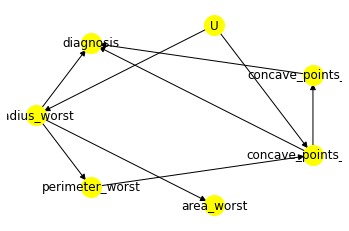

In [32]:

#display(Image(filename="causal_model.png"))
model.view_model()

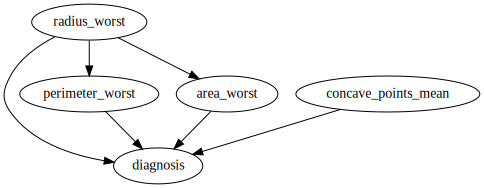

In [33]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['diagnosis','radius_worst','area_worst','perimeter_worst','concave_points_mean','concave_points_mean'],
    edges=[
        ("radius_worst", "perimeter_worst"), 
        ("radius_worst", "area_worst"),
       
        ("radius_worst","diagnosis"),
        ("area_worst","concave_points_worst"),
        ("perimeter_worst","concave_points_worst"),
        ("concave_points_mean","concave_points_worst"),
       
        ("area_worst","diagnosis"),
        ("perimeter_worst","diagnosis"),
        ("concave_points_mean","diagnosis"),
        ("concave_points_worst","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()

Identify the Causal Effect

In [34]:
estimands = model.identify_effect()
print(estimands)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                               
───────────────(Expectation(diagnosis))
d[radius_worst]                        
Estimand assumption 1, Unconfoundedness: If U→{radius_worst} and U→diagnosis then P(diagnosis|radius_worst,,U) = P(diagnosis|radius_worst,)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Estimate the Causal Effect based on the different methods

In [35]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(estimands,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = data[data["diagnosis"]==1]
data_0 = data[data["diagnosis"]==0]

print("ATE", np.mean(data_1["radius_worst"])- np.mean(data_0["radius_worst"]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                               
───────────────(Expectation(diagnosis))
d[radius_worst]                        
Estimand assumption 1, Unconfoundedness: If U→{radius_worst} and U→diagnosis then P(diagnosis|radius_worst,,U) = P(diagnosis|radius_worst,)

## Realized estimand
b: diagnosis~radius_worst
Target units: ate

## Estimate
Mean value: 0.3754096049015073
p-value: [8.48229192e-116]

Causal Estimate is 0.3754096049015073
ATE 1.605927132452262
